pybullet build time: Feb  1 2023 20:12:59
2023-09-13 15:27:57.807503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 15:27:57.894056: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-13 15:27:57.896095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/baha/anaconda3/envs/gym-env/lib/pyt

argv[0]=--mp4=test.mp4
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --mp4=test.mp4
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Graphics (RKL GT1)
GL_VERSION=4.6 (Core Profile) Mesa 23.0.4-0ubuntu1~22.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 23.0.4-0ubuntu1~22.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Graphics (RKL GT1)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Inte

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

numActiveThreads = 0
stopping threads
destroy semaphore
Thread with taskId 0 exiting
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


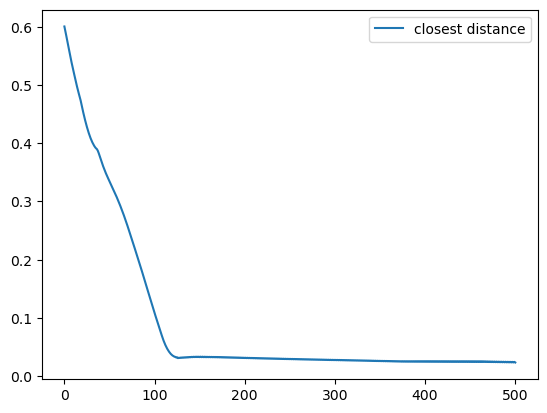

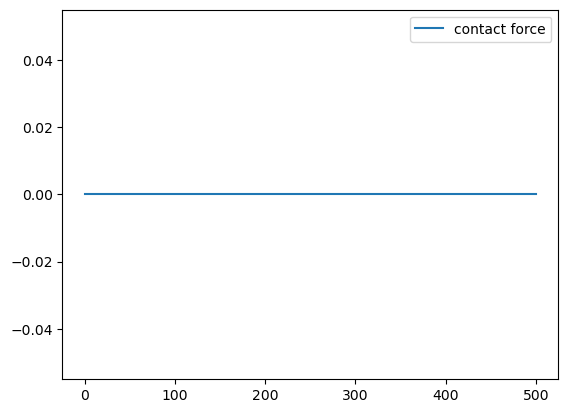

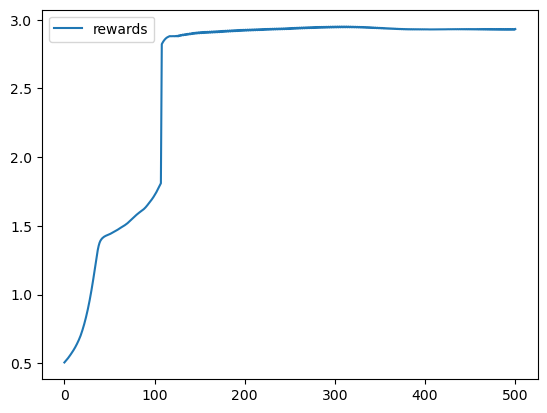

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import gymnasium
sys.modules["gym"] = gymnasium
import pybullet as p
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
# from robotiqGymEnv import robotiqGymEnv
from newenv import robotiqGymEnv
import numpy as np
import csv

def load_model(file_path):
    """
    Load the model from the given file path
    """
    return SAC.load(file_path)

def extract_data(env, model, obs, steps):
    """
    Run the model prediction and extract data into arrays
    """
    position_action_data = []
    angle_action_data = []
    gripper_position_data = []
    gripper_angle_data = []
    gripper_velocity_data = []
    gripper_angular_velocity_data = []
    target_position_data = []
    target_angle_data = []
    target_velocity_data = []
    target_angular_velocity_data = []
    closest_point_data = []
    contact_force_data = []
    rewards_data = []
    done = False

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, info = env.step(action)
        env.render()

        base_pos, base_orientation = p.getBasePositionAndOrientation(env._robotiq.robotiq_uid)
        target_pos, target_orientation = p.getBasePositionAndOrientation(env.blockUid)

        base_velocity, base_angular_velocity = p.getBaseVelocity(env._robotiq.robotiq_uid)
        target_velocity, target_angular_velocity = p.getBaseVelocity(env.blockUid)

        gripper_angle = p.getEulerFromQuaternion(base_orientation)
        target_angle = p.getEulerFromQuaternion(target_orientation)

        position_action_data.append(action[0:3])
        angle_action_data.append(action[3:6])
        gripper_position_data.append(base_pos)
        gripper_angle_data.append(gripper_angle)
        gripper_velocity_data.append(base_velocity)
        gripper_angular_velocity_data.append(base_angular_velocity)
        target_position_data.append(target_pos)
        target_angle_data.append(target_angle)
        target_velocity_data.append(target_velocity)
        target_angular_velocity_data.append(target_angular_velocity)
        closest_point_data.append(p.getClosestPoints(env._robotiq.robotiq_uid, env.blockUid, 100, -1, -1)[0][8])
        contact_force_data.append(env._contactinfo()[4])
        rewards_data.append(rewards)
        
    return position_action_data, angle_action_data, gripper_position_data, gripper_angle_data, gripper_velocity_data, gripper_angular_velocity_data, target_position_data, target_angle_data, target_velocity_data, target_angular_velocity_data, closest_point_data, contact_force_data, rewards_data

def plot_data(data, labels):
    """
    Plot the data using matplotlib
    """
    plt.figure()
    for d, label in zip(data, labels):
        plt.plot(d, label=label)
        plt.legend()

def save_to_csv(filename, data_dict):
    """
    Save data to CSV

    :param filename: Name of the file to save to
    :param data_dict: Dictionary containing labels as keys and data as values
    """

    # Get max length of rows for data arrays
    max_length = max(len(v) for v in data_dict.values())

    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # Write header
        headers = list(data_dict.keys())
        csv_writer.writerow(headers)

        # Write rows
        for i in range(max_length):
            row = [data_dict[header][i] if i < len(data_dict[header]) else "" for header in headers]
            csv_writer.writerow(row)


def main():
    """
    Main function to run the program
    """
    model_file = "models/20230316-03:42PM_SAC_M10000_0.04_39/best_model.zip"
    model = load_model(model_file)

    with robotiqGymEnv(records=True, renders=False) as env:
        obs = env.reset()
        steps = range(500) # define the number of steps here
        position_action_data, angle_action_data, gripper_position_data, gripper_angle_data, gripper_velocity_data, gripper_angular_velocity_data, target_position_data, target_angle_data, target_velocity_data, target_angular_velocity_data, closest_point_data, contact_force_data, rewards_data = extract_data(env, model, obs, steps)


    # plot_data(zip(*position_action_data), ["x action", "y action", "z action"])
    # plot_data(zip(*angle_action_data), ["roll action", "pitch action", "yaw action"])
    # plot_data(zip(*gripper_position_data), ["x position", "y position", "z position"])
    # plot_data(zip(*gripper_angle_data), ["gripper roll", "gripper pitch", "gripper yaw"])
    # plot_data(zip(*target_position_data), ["target x position", "target y position", "target z position"])
    # plot_data(zip(*target_angle_data), ["target roll", "target pitch", "target yaw"])
    plot_data([closest_point_data], ["closest distance"])
    plot_data([contact_force_data], ["contact force"])
    plot_data([rewards_data], ["rewards"])

    data_dict = {
        "x action": [data[0] for data in position_action_data],
        "y action": [data[1] for data in position_action_data],
        "z action": [data[2] for data in position_action_data],
        "roll action": [data[0] for data in angle_action_data],
        "pitch action": [data[1] for data in angle_action_data],
        "yaw action": [data[2] for data in angle_action_data],
        "x gripper": [data[0] for data in gripper_position_data],
        "y gripper": [data[1] for data in gripper_position_data],
        "z gripper": [data[2] for data in gripper_position_data],
        "roll gripper": [data[0] for data in gripper_angle_data],
        "pitch gripper": [data[1] for data in gripper_angle_data],
        "yaw gripper": [data[2] for data in gripper_angle_data],
        "x velocity gripper": [data[0] for data in gripper_velocity_data],
        "y velocity gripper": [data[1] for data in gripper_velocity_data],
        "z velocity gripper": [data[2] for data in gripper_velocity_data],
        "x angular velocity gripper": [data[0] for data in gripper_angular_velocity_data],
        "y angular velocity gripper": [data[1] for data in gripper_angular_velocity_data],
        "z angular velocity gripper": [data[2] for data in gripper_angular_velocity_data],
        "x target": [data[0] for data in target_position_data],
        "y target": [data[1] for data in target_position_data],
        "z target": [data[2] for data in target_position_data],
        "roll target": [data[0] for data in target_angle_data],
        "pitch target": [data[1] for data in target_angle_data],
        "yaw target": [data[2] for data in target_angle_data],
        "x velocity target": [data[0] for data in target_velocity_data],
        "y velocity target": [data[1] for data in target_velocity_data],
        "z velocity target": [data[2] for data in target_velocity_data],
        "x angular velocity target": [data[0] for data in target_angular_velocity_data],
        "y angular velocity target": [data[1] for data in target_angular_velocity_data],
        "z angular velocity target": [data[2] for data in target_angular_velocity_data],
        "closest distance": closest_point_data,
        "contact force": contact_force_data,
        "rewards": rewards_data
    }

    save_to_csv("output_data30.csv", data_dict)

    gripper_position_data = np.array(gripper_position_data)
    gripper_final_position = np.mean(gripper_position_data[-100:, :], axis=0)
    target_position_data = np.array(target_position_data)
    target_final_position = np.mean(target_position_data[-100:, :], axis=0)
    # print("gripper final position: ", gripper_final_position)
    # print("target final position: ", target_final_position)
    D = 2628.9
    sat = 476.6
    robot_gripper_pose = [gripper_final_position[1]*1000, gripper_final_position[0]*1000, gripper_final_position[2]*1000]
    robot_sat_pose = [D - sat - target_final_position[1]*1000 - 100, - target_final_position[0]*1000, target_final_position[2]*1000 + 30]
    # print("robot gripper pose: ", robot_gripper_pose)
    # print("robot sat pose: ", robot_sat_pose)


if __name__ == "__main__":
    main()
